# Logic analysis


Hooking up the logic analyser to the `SPI` pins of `Hulk Board`, I captured various events.

The raw waveform look pretty clean and can be analysed to decipher the protocol in a practical environment. Here's a screenshot of the anlayser data:

![Logic Analyser Data](../data/media/power-cycle-logic-wf.png)


### Analysis goals

- Find the `LUT` table being sent. Specifically, we want the full LUT buffer from:

| Command    | Buffer |
|------------|-------:|
| LUT_KWVCOM |   32 B |
| LUT_KW     |  512 B |
| LUT_FT     |  128 B |

- Order of commands and correct power up/down sequences.
- Eventually, move to a hardware `SPI`, instead of bit-banging that sample code uses.




In [2]:
from pydash import py_

from tools.analyser import LogicData

In [29]:
# Load the logic analyser data to the dataframe, and parse it:

_seq_path = lambda x: f'../data/logic-analysis/{x}.csv'

# Black-white fill sequence
sq_bw = LogicData.from_csv(_seq_path('black-white-fill'))

# Refresh Seqence
sq_ref = LogicData.from_csv(_seq_path('refresh-seq'))

# Power on cycle
sq_pon = LogicData.from_csv(_seq_path('power-on-cycle'))

# Slide show
sq_show = LogicData.from_csv(_seq_path('slide-show'))


# Little Capture
sq_lcp = LogicData.from_csv(_seq_path('lil-cap'))

# 20 sec Capture
sq_long = LogicData.from_csv(_seq_path('cap-20s'))

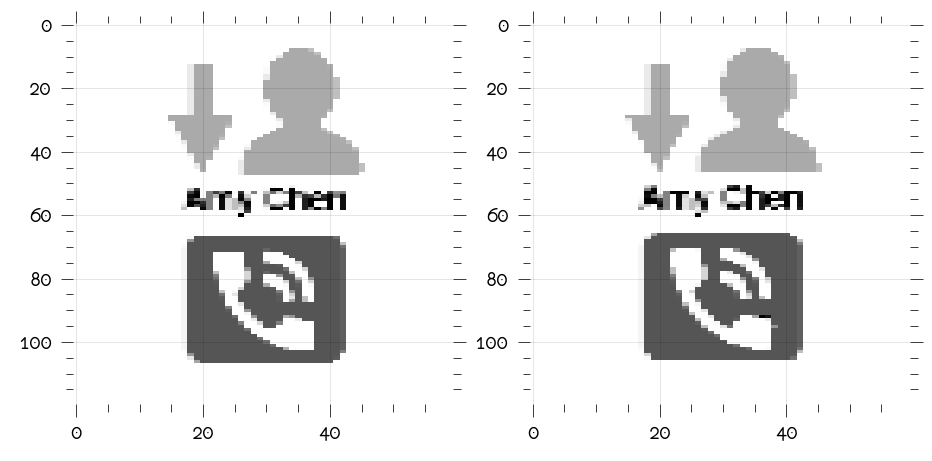

In [76]:
# Show all the commands that were sent to the device.
# The analyser sets a `flag` to False if the data is interpreted as command.
# A command is identified by checking the bit value at `9`th MSB position.

# These were also decoded with the command name in datasheet as can be found in
# tools.consts module.

ix = sq_lcp.df[8:14408].v_data.values.reshape(120, 120)

ix_a = ix[:,:60]
ix_b = ix[:,60:]

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(ix_a, aspect=0.5)
plt.subplot(122)
plt.imshow(ix_b, aspect=0.5)

In [41]:
# Let's analyse an image data and attempt to get the actual image.

sq_show.df[678:686]

# Note the row `DTMW` on index 679.
# This is where data write starts.
# Next few commands are gonna be used to set up parameters for displayed images.


,t,data,flag,cmd,v_data
678,3.4251,0x100,True,,0
679,3.4252,0x014,False,DTMW,20
680,3.4253,0x100,True,,0
681,3.4253,0x100,True,,0
682,3.4254,0x100,True,,0
683,3.4255,0x1EF,True,,239
684,3.4256,0x100,True,,0
685,3.4257,0x1EF,True,,239


### Interpretation of Data


```
t	data	flag	cmd
679	3.4252	0x014	False	DTMW
680	3.4253	0x100	True	     <-- Window X
681	3.4253	0x100	True	     <-- Window Y
682	3.4254	0x100	True	     
683	3.4255	0x1EF	True	     <-- Window Width; 0xEF = 240
684	3.4256	0x100	True	
685	3.4257	0x1EF	True	     <-- Window Length
```

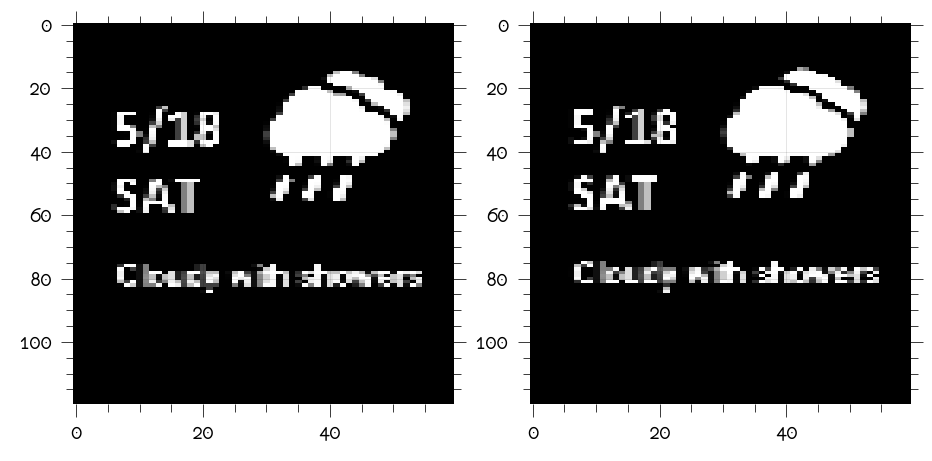

In [117]:
# Again, for power-on data
ix = sq_pon.df[8:14408].v_data.values.reshape(120, 120)

ix_a = ix[:,:60]
ix_b = ix[:,60:]

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(ix_a, aspect=0.5)
plt.subplot(122)
plt.imshow(ix_b, aspect=0.5)



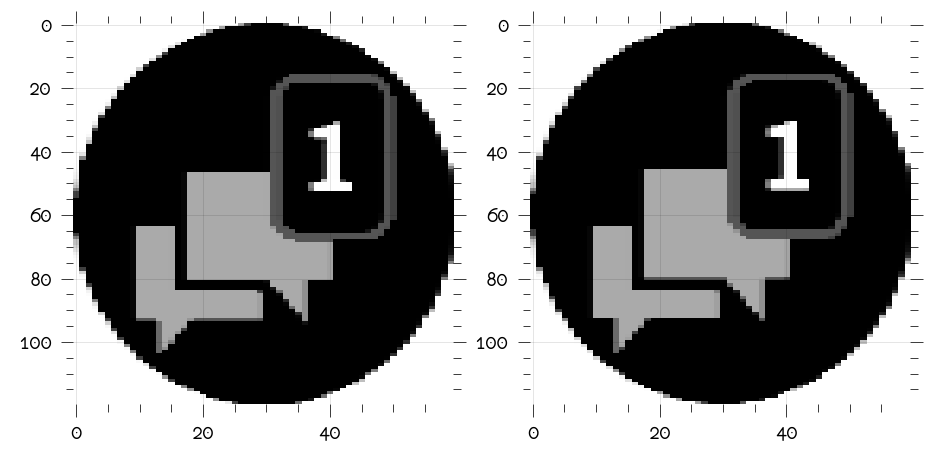

In [77]:
ix = sq_ref.df[8:14408].v_data.values.reshape(120, 120)

ix_a = ix[:,:60]
ix_b = ix[:,60:]

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(ix_a, aspect=0.5)
plt.subplot(122)
plt.imshow(ix_b, aspect=0.5)



In [69]:
# LUT Values for KWVCOM

display(sq_bw.df.query('cmd == "LUT_KWVCOM"'))

display(sq_bw.df[5: 37].v_data.values)

display(sq_bw.df[7901: 7933].v_data.values)

,t,data,flag,cmd,v_data
4,2.4658,0x020,False,LUT_KWVCOM,32
7900,5.1313,0x020,False,LUT_KWVCOM,32


array([  0,   0,   0,   0,   0,   0,   0,   0, 192,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

array([  0,   0,   0,   0,   0,   0,   0,   0, 192,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [169]:
def decompose_frame(frame):
  '''Decompose Frame Bits.

  2bit and 1bit images are encoded and written to Registers at 0x10, 0x13, 0x15, and 0x16.

  Basically, each byte contains either four pixels for 2bit images, or 8 pixels for 1bit images.
  The schemes are:

  - DTM1 - 2bit image goes in _old_ `SRAM`.
  - DTM2 - 2bit image goes in _new_ `SRAM`.
  - DTM3 - 1bit image (8 pixel per byte) goes to _old_ `SRAM`.
  - DTM4 - 1bit image (8 pixel per byte) goes to _new_ `SRAM`.

  The encoding scheme for register 0x10 is as following:
  
  ┌───┐ ┌───┬───┐┌───┬───┐┌───┬───┐┌───┬───┐
  │ 1 │ │   │   ││   │   ││   │   ││   │   │
  └───┘ └───┴───┘└───┴───┘└───┴───┘└───┴───┘
   DC   ─ 7 ─── 8 Bits Transmission ──── 0 ─ 

        ─────────                            Px (n-4)
                 ─────────                   Px (n-3)
                          ─────────          Px (n-2)
                                   ───────── Px (n-1)

  Each data byte is shifted left by two bits to obtain the complete frame.
  '''
  # Composed image is 4x the size of frame.
  c_pxs = np.zeros(len(frame) * 4)
  for i in range(4):
    c_pxs[3 - i::4] = (frame >> (2 * i)) & 0b11
  return c_pxs

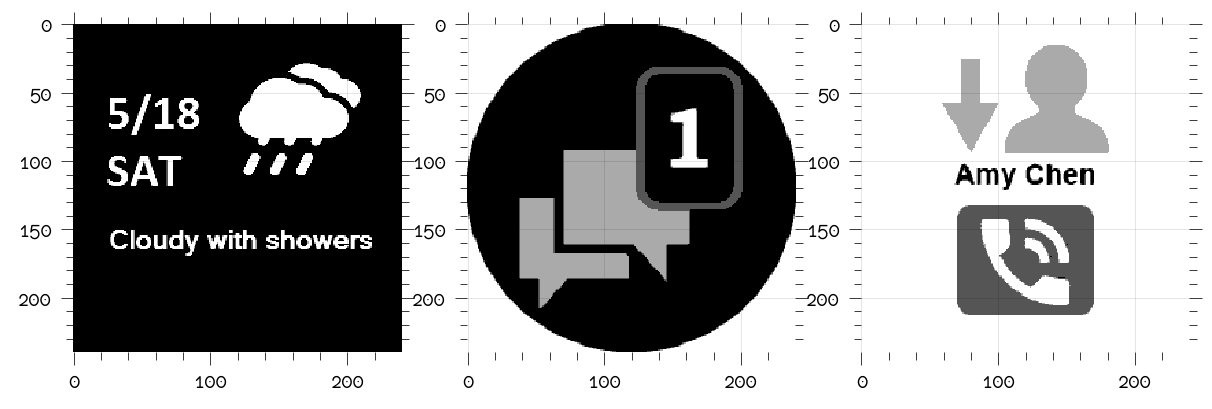

In [170]:
for i, sq in enumerate([sq_pon, sq_ref, sq_lcp]):
  i_coded = sq.df[8:14408].v_data.values
  img_seq = decompose_frame(i_coded).reshape(240, 240)
  
  plt.subplot(1, 3, i + 1)
  plt.imshow(img_seq, cmap=plt.cm.gray, aspect=1)


In [192]:
# Decode PSR sequence:

display(sq_pon.df[15106:15120])

REG_EN = lambda x: 'Internal' if bool(x & 0b1000_0000) else 'MCU'
IMCP = lambda x: bool(x & 0b100)
SHL = lambda x: 'Left' if bool(x & 0b100) else 'Right'
SHD_N = lambda x: bool(x & 0b10)
RST_N = lambda x: 'Nothing' if bool(x & 0b1) else 'Assert Reset'


# Analysing PSR sequence:
sq1 = sq_pon.df.v_data[15107]
sq2 = sq_pon.df.v_data[15108]

print('LUT Source:', REG_EN(sq2))
print('Copy to old Flash:', IMCP(sq2))
print('Booster Shut Down:', SHD_N(sq1))
print('Source Shifts:', SHL(sq1))
print('On Reset:', RST_N(sq1))


,t,data,flag,cmd,v_data
15106,2.7057,0x000,False,PSR,0
15107,2.7057,0x10B,True,,11
15108,2.7057,0x186,True,,134
15109,2.7058,0x003,False,PFS,3
15110,2.7058,0x100,True,,0
15111,2.7058,0x030,False,LPRD,48
15112,2.7059,0x125,True,,37
15113,2.7059,0x041,False,TSE,65
15114,2.7059,0x100,True,,0
15115,2.7059,0x050,False,CDI,80


LUT Source: Internal
Copy to old Flash: True
Booster Shut Down: True
Source Shifts: Right
On Reset: Nothing
